In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn. preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn. linear_model import LinearRegression
from sklearn. linear_model import Ridge, RidgeCV
from sklearn. compose import ColumnTransformer
import time



In [6]:
data = pd.read_csv("./X_train.csv")
data.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


In [7]:
data.columns

Index(['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id'],
      dtype='object')

In [8]:
idx = np.hstack((0,data[data.t == 10].index.values +1))
idx. shape, data. t.min(), data. t.max()

((4054,), np.float64(0.0), np.float64(10.0))

2107


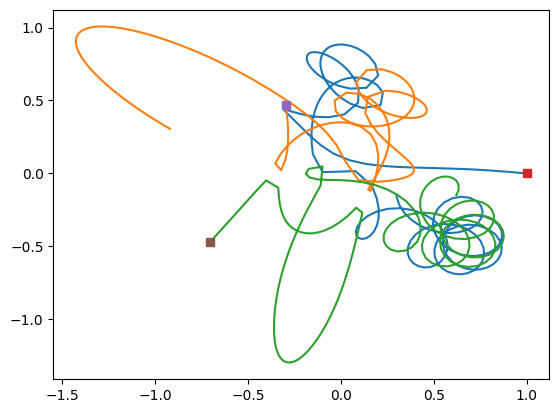

In [9]:
k = np.random. randint(idx. shape [0])
print(k)
pltidx = range(idx[k],257+idx[k])
pltsquare = idx [k]
plt.plot(data.x_1[pltidx],data.y_1[pltidx])
plt.plot(data.x_2[pltidx],data.y_2[pltidx])
plt.plot(data.x_3[pltidx],data.y_3[pltidx])

plt.plot(data.x_1[pltsquare],data.y_1[pltsquare],'s')
plt.plot(data.x_2[pltsquare],data.y_2[pltsquare], 's' )
plt.plot(data.x_3[pltsquare],data.y_3[pltsquare],'s')

In [10]:
def split_by_initial_positions(data, test_size=0.15, val_size=0.15, random_state=42):
    # Step 1: Identify trajectories by grouping consecutive timesteps
    # Assumption: data is ordered so each block of timesteps (0–10) is one trajectory
    data = data.sort_values(['t']).reset_index(drop=True)

    # Assign traj_id by dividing the dataframe into chunks of (t_max+1) rows
    timesteps = data['t'].nunique()   # should be 11
    data['traj_id'] = data.index // timesteps

    # Step 2: split trajectory IDs
    traj_ids = data['traj_id'].unique()
    train_ids, temp_ids = train_test_split(traj_ids, test_size=test_size+val_size, random_state=random_state)
    val_ids, test_ids = train_test_split(temp_ids, test_size=test_size/(test_size+val_size), random_state=random_state)

    # Step 3: return splits
    train_data = data[data['traj_id'].isin(train_ids)]
    val_data   = data[data['traj_id'].isin(val_ids)]
    test_data  = data[data['traj_id'].isin(test_ids)]

    return train_data, val_data, test_data


In [11]:
train_data, val_data, test_data = split_by_initial_positions(data)

In [12]:
print(len(train_data), len(val_data), len(test_data))
print("Train trajectories:", train_data['traj_id'].nunique())
print("Val trajectories:", val_data['traj_id'].nunique())
print("Test trajectories:", test_data['traj_id'].nunique())

899500 192750 192750
Train trajectories: 3500
Val trajectories: 750
Test trajectories: 750


In [13]:
train_ids = set(train_data['traj_id'].unique())
val_ids   = set(val_data['traj_id'].unique())
test_ids  = set(test_data['traj_id'].unique())

print("Overlap train/val:", train_ids & val_ids)
print("Overlap train/test:", train_ids & test_ids)
print("Overlap val/test:", val_ids & test_ids)

Overlap train/val: set()
Overlap train/test: set()
Overlap val/test: set()


In [14]:
for subset, name in [(train_data,"train"),(val_data,"val"),(test_data,"test")]:
    traj_counts = subset.groupby("traj_id")['t'].nunique()
    print(f"{name} min timesteps:", traj_counts.min(), "max timesteps:", traj_counts.max())


train min timesteps: 1 max timesteps: 2
val min timesteps: 1 max timesteps: 2
test min timesteps: 1 max timesteps: 2


In [15]:
print("Full dataset timestep range:", data["t"].min(), "to", data["t"].max())
print(data["t"].value_counts().sort_index())


Full dataset timestep range: 0.0 to 10.0
t
0.000000     200208
0.039062       4955
0.078125       4898
0.117188       4835
0.156250       4765
              ...  
9.843750       4057
9.882810       4056
9.921880       4056
9.960940       4054
10.000000      4053
Name: count, Length: 257, dtype: int64


In [16]:
print("Train timesteps:", train_data["t"].min(), train_data["t"].max())
print("Val timesteps:", val_data["t"].min(), val_data["t"].max())
print("Test timesteps:", test_data["t"].min(), test_data["t"].max())

Train timesteps: 0.0 10.0
Val timesteps: 0.0 10.0
Test timesteps: 0.0 10.0


# Three-Body Problem Prediction

## Task 1: Setting the Baseline

The goal is to predict the movement of three bodies on a 2D plane given their initial positions, without using numerical solvers. At the initial positions, all velocities are zero.

### Data Description:
- For each body i (i = 1,2,3):
  - Position: $(x_i, y_i)$
  - Velocity: $(v_{x_i}, v_{y_i})$

### Task 1.1: Data Preparation and Validation Pipeline

In [17]:
# Load the training and test data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')

# Display basic information about the datasets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nTraining set columns:", X_train.columns.tolist())

Training set shape: (1285000, 14)
Test set shape: (1041621, 8)

Training set columns: ['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id']


Let's analyze the structure of our data and prepare our validation pipeline. We need to:
1. Understand the data structure
2. Check for missing values
3. Split the data for validation
4. Define evaluation metrics

In [18]:
# 1. Data Structure Analysis
# Check the first few rows and basic statistics
print("First few rows of training data:")
display(X_train.head())

print("\nBasic statistics of training data:")
display(X_train.describe())

# 2. Check for missing values
print("\nMissing values in training data:")
print(X_train.isnull().sum())

# 3. Prepare validation split
# We'll use the last 20% of each trajectory for validation
validation_split = 0.2
n_samples = len(X_train)
n_val = int(n_samples * validation_split)

# Split the data
X_train_final = X_train[:-n_val]
X_val = X_train[-n_val:]

print("\nFinal split sizes:")
print(f"Training set: {len(X_train_final)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

First few rows of training data:


,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4



Basic statistics of training data:


,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
count,1.285000e+06,1.285000e+06,1.285000e+06,1.285000e+06,1.285000e+06,1.285000e+06,1.285000e+06,1.285000e+06,1.285000e+06,1.285000e+06,1.285000e+06,1.285000e+06,1.285000e+06,1.285000e+06
mean,4.145262e+00,-2.812879e-01,-1.095159e-01,-1.841267e-01,-1.650011e-02,7.171403e-03,-8.201144e-02,3.247712e-02,-8.360838e-02,2.741165e-01,1.915273e-01,1.516496e-01,1.001085e-01,6.424995e+05
std,3.209813e+00,1.695764e+00,1.167686e+00,8.775115e-01,8.064175e-01,1.062984e+00,1.038606e+00,9.362290e-01,9.751777e-01,1.443411e+00,1.683294e+00,7.878988e-01,8.709405e-01,3.709477e+05
min,0.000000e+00,-3.082300e+01,-1.785773e+01,-7.299333e+01,-2.310928e+01,-3.083340e+01,-5.245081e+01,-2.589555e+01,-4.828901e+01,-1.743999e+01,-3.316000e+01,-3.097054e+01,-2.550938e+01,0.000000e+00
25%,1.054690e+00,-4.118489e-01,-3.928434e-01,-5.782370e-01,-2.266108e-01,-3.295574e-01,-1.918623e-01,-2.983937e-01,-4.984175e-01,-4.324075e-01,-4.472183e-01,-1.019181e-01,-2.062900e-01,3.212498e+05
50%,3.945310e+00,0.000000e+00,0.000000e+00,-6.909794e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.306061e-04,6.181826e-02,1.402483e-02,6.424995e+05
75%,6.953120e+00,5.008268e-01,2.634242e-01,1.321657e-01,2.444148e-01,2.103091e-01,2.683916e-01,3.880151e-01,3.262901e-01,5.005791e-01,3.508870e-01,4.864241e-01,4.975648e-01,9.637492e+05
max,1.000000e+01,1.634061e+01,2.627623e+01,2.350346e+01,3.467168e+01,1.550696e+01,3.567946e+01,7.271823e+01,2.311835e+01,6.165640e+01,2.773554e+01,2.596499e+01,4.828874e+01,1.284999e+06



Missing values in training data:
t        0
x_1      0
y_1      0
v_x_1    0
v_y_1    0
x_2      0
y_2      0
v_x_2    0
v_y_2    0
x_3      0
y_3      0
v_x_3    0
v_y_3    0
Id       0
dtype: int64

Final split sizes:
Training set: 1028000 samples
Validation set: 257000 samples
Test set: 1041621 samples


In [19]:
# 4. Define evaluation metrics
def calculate_mse(y_true, y_pred):
    """Calculate Mean Squared Error for position predictions"""
    return np.mean((y_true - y_pred) ** 2)

def calculate_trajectory_error(true_positions, pred_positions):
    """Calculate the average error across the entire trajectory"""
    return np.mean([calculate_mse(true, pred) for true, pred in zip(true_positions, pred_positions)])

# Example of how we'll use these metrics
print("Evaluation metrics are ready to use for:")
print("- Position-wise MSE")
print("- Trajectory-wise average error")

Evaluation metrics are ready to use for:
- Position-wise MSE
- Trajectory-wise average error


### Visualization of Sample Trajectories

Let's visualize some sample trajectories to better understand the data:

# Three-Body Problem Prediction Challenge

The goal is to predict the movement of three bodies on a 2D plane given their initial positions, without using numerical solvers. At initial positions, all velocities are zero.

## Data Understanding

Each trajectory in our dataset:
- Contains 258 timesteps
- Includes position $(x, y)$ and velocity $(v_x, v_y)$ for each body
- May contain zeros after collisions
- Starts with zero velocities

In [20]:
# Load the training data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Display first few rows to understand the structure
print("\nFirst few rows of training data:")
print(X_train.head())

Training set shape: (1285000, 14)
Test set shape: (1041621, 8)

First few rows of training data:
          t       x_1       y_1     v_x_1     v_y_1       x_2       y_2  \
0  0.000000  1.000000  0.000000  0.000000  0.000000 -0.266467  0.859196   
1  0.039062  0.999548  0.000092 -0.023159  0.004731 -0.266261  0.858781   
2  0.078125  0.998190  0.000370 -0.046362  0.009474 -0.265641  0.857535   
3  0.117188  0.995925  0.000833 -0.069654  0.014239 -0.264606  0.855456   
4  0.156250  0.992747  0.001483 -0.093080  0.019040 -0.263154  0.852540   

      v_x_2     v_y_2       x_3       y_3     v_x_3     v_y_3  Id  
0  0.000000  0.000000 -0.733533 -0.859196  0.000000  0.000000   0  
1  0.010574 -0.021257 -0.733287 -0.858874  0.012584  0.016526   1  
2  0.021172 -0.042552 -0.732549 -0.857905  0.025189  0.033078   2  
3  0.031817 -0.063924 -0.731318 -0.856289  0.037837  0.049685   3  
4  0.042533 -0.085412 -0.729592 -0.854022  0.050548  0.066372   4  


In [21]:
# Function to reshape the data into trajectories
def reshape_trajectories(data, n_timesteps=258):
    # Each trajectory has 12 features (x, y, vx, vy for each of the 3 bodies)
    n_features = 12
    n_trajectories = len(data) // n_timesteps
    
    # Reshape the data into (n_trajectories, n_timesteps, n_features)
    trajectories = data.values.reshape(n_trajectories, n_timesteps, n_features)
    
    return trajectories

# Reshape the training data
trajectories = reshape_trajectories(X_train)

print("Number of trajectories:", trajectories.shape[0])
print("Number of timesteps per trajectory:", trajectories.shape[1])
print("Number of features per timestep:", trajectories.shape[2])

ValueError: cannot reshape array of size 17990000 into shape (4980,258,12)

In [ ]:
# Function to check for collisions (where all values become zero)
def detect_collisions(trajectory):
    # Sum all features at each timestep - if zero, it indicates a collision
    timestep_sums = np.sum(np.abs(trajectory), axis=1)
    collision_mask = timestep_sums == 0
    
    if np.any(collision_mask):
        first_collision = np.argmax(collision_mask)
        return first_collision
    return None

# Analyze collisions in trajectories
collision_timesteps = []
for i in range(len(trajectories)):
    collision_time = detect_collisions(trajectories[i])
    if collision_time is not None:
        collision_timesteps.append(collision_time)

print(f"Number of trajectories with collisions: {len(collision_timesteps)}")
if collision_timesteps:
    print(f"Average timestep of first collision: {np.mean(collision_timesteps):.2f}")
    print(f"Earliest collision at timestep: {min(collision_timesteps)}")
    print(f"Latest collision at timestep: {max(collision_timesteps)}")

## Trajectory Visualization

Let's visualize some sample trajectories to better understand the movement patterns and collision behaviors.

In [ ]:
# Function to plot a single trajectory
def plot_trajectory(trajectory, title="Three-Body Trajectory"):
    plt.figure(figsize=(12, 8))
    
    # Colors for each body
    colors = ['b', 'r', 'g']
    labels = ['Body 1', 'Body 2', 'Body 3']
    
    for i in range(3):
        # Extract positions for each body
        x = trajectory[:, i*4]    # x position
        y = trajectory[:, i*4+1]  # y position
        
        # Plot trajectory
        plt.plot(x, y, color=colors[i], label=labels[i], alpha=0.6)
        # Plot starting point
        plt.scatter(x[0], y[0], color=colors[i], marker='o', s=100)
        
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Plot a few sample trajectories
for i in range(3):
    plot_trajectory(trajectories[i], f"Trajectory {i+1}")
    
# Plot a trajectory with collision (if any exist)
if collision_timesteps:
    collision_idx = np.argmin(collision_timesteps)  # Get trajectory with earliest collision
    plot_trajectory(trajectories[collision_idx], "Trajectory with Early Collision")

## Data Statistics and Distribution Analysis

Let's analyze the statistical properties of our dataset to better understand the range and distribution of positions and velocities.

In [ ]:
# Calculate basic statistics for positions and velocities
feature_names = []
for i in range(1, 4):
    feature_names.extend([f'x{i}', f'y{i}', f'vx{i}', f'vy{i}'])

# Get statistics for each feature
stats = X_train.describe()
stats.columns = feature_names
print("Dataset Statistics:")
print(stats)

# Plot distributions of initial positions and velocities
plt.figure(figsize=(15, 10))

# Initial positions
for i in range(6):  # First 6 columns are positions (x1,y1,x2,y2,x3,y3)
    plt.subplot(2, 3, i+1)
    initial_values = trajectories[:, 0, i]
    sns.histplot(initial_values, bins=30)
    plt.title(f'Initial {feature_names[i]} Distribution')
    plt.xlabel(feature_names[i])
    
plt.tight_layout()
plt.show()

# Verify that initial velocities are zero
initial_velocities = trajectories[:, 0, 6:]  # Velocities start from index 6
print("\nVerifying initial velocities:")
print("Max absolute initial velocity:", np.abs(initial_velocities).max())
print("Mean absolute initial velocity:", np.abs(initial_velocities).mean())